# CSV Transform Demo

Demonstrates how to use `DataFrameTransformer` to transform real data from CSV files or pandas DataFrames.

The `DataFrameTransformer` handles everything internally:
- Creating centers along coordinate axes
- Building the TensorBasis
- Running Levenberg-Marquardt optimization
- Transforming points

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from entra import DataFrameTransformer, VectorSampler, plot_covariance_ellipse

## Step 1: Sample Points Using VectorSampler

In [11]:
# Parameters
num_points_per_dim = 20
delta_x = 1

# Create sampler centered at origin
sampler = VectorSampler(
    center=[0.0, 0.0],
    delta_x=delta_x,
    num_points_per_dim=num_points_per_dim,
    distribution="uniform"
)

# Sample the grid points
points = sampler.sample()
J = sampler.J

print(f"Grid: {num_points_per_dim} x {num_points_per_dim} = {J} points")
print(f"Points shape: {points.shape}")

Grid: 20 x 20 = 400 points
Points shape: (400, 2)


In [12]:
# Create DataFrame and save to CSV
df = pd.DataFrame({'x': points[:, 0], 'y': points[:, 1]})
input_csv = '/tmp/sample_vectors.csv'
df.to_csv(input_csv, index=False)

print(f"Saved {len(df)} points to: {input_csv}")
df.head()

Saved 400 points to: /tmp/sample_vectors.csv


,x,y
0,-9.5,-9.5
1,-9.5,-8.5
2,-9.5,-7.5
3,-9.5,-6.5
4,-9.5,-5.5


## Step 2: Transform Using DataFrameTransformer

The `DataFrameTransformer` handles everything internally:
- Creates centers along coordinate axes (same pattern as `covariance_optimization.ipynb`)
- Builds the `TensorBasis` with the specified `sigma`
- Runs Levenberg-Marquardt optimization to minimize covariance determinant
- Returns transformed DataFrame

**Note:** H(Gaussian) is the entropy IF the distribution were Gaussian with the current covariance. It decreases because we start from uniform.

In [13]:
# Create transformer
transformer = DataFrameTransformer(
    sigma=5.0,
    max_iterations=1000,
    tolerance=1e-18,
    verbose=True
)

# Fit and transform
df_transformed = transformer.fit_transform(df, columns=['x', 'y'])

Fitting transformer: 400 points, 2 dimensions
  sigma = 5.0
  L = 36 basis centers

  Note: H(Gaussian) is the entropy IF the distribution were Gaussian with
  the current covariance. It decreases because we start from uniform.

   Iter     Determinant   H(Gaussian)      Lambda
  --------------------------------------------------
      0    1.111111e+03        6.3444    1.00e+00
      1    1.111108e+03        6.3444    1.00e-01
      2    1.111079e+03        6.3444    1.00e-02
      3    1.110790e+03        6.3443    1.00e-03
      4    1.107916e+03        6.3430    1.00e-04
      5    1.080888e+03        6.3306    1.00e-05
     50    9.358081e+02        6.2586    1.00e-04
    150    9.347977e+02        6.2580    1.00e-04
    250    9.338234e+02        6.2575    1.00e-04
    350    9.328586e+02        6.2570    1.00e-04
    450    9.318859e+02        6.2565    1.00e-04
    550    9.296247e+02        6.2553    1.00e-04
    600    9.183377e+02        6.2492    1.00e-04
    650    8.49643

## Step 3: Entropy Comparison

In [14]:
# Get entropy comparison
entropy = transformer.get_entropy_comparison(df, df_transformed)

print("Entropy Comparison:")
print(f"  Original uniform entropy: {entropy['original']['uniform_entropy']:.6f} nats")
print(f"  Original k-NN entropy:    {entropy['original']['knn_entropy']:.6f} nats")
print(f"  Transformed k-NN entropy: {entropy['transformed']['knn_entropy']:.6f} nats")
print(f"  Transformed Gaussian H:   {entropy['transformed']['gaussian_entropy']:.6f} nats")
print()
print("Covariance Determinant:")
print(f"  Original:    {entropy['original']['determinant']:.6e}")
print(f"  Transformed: {entropy['transformed']['determinant']:.6e}")
print(f"  Reduction:   {entropy['original']['determinant'] / entropy['transformed']['determinant']:.2f}x")

Entropy Comparison:
  Original uniform entropy: 5.888878 nats
  Original k-NN entropy:    7.605385 nats
  Transformed k-NN entropy: 6.365254 nats
  Transformed Gaussian H:   5.748947 nats

Covariance Determinant:
  Original:    1.111111e+03
  Transformed: 3.376939e+02
  Reduction:   3.29x


## Step 4: Optimization History

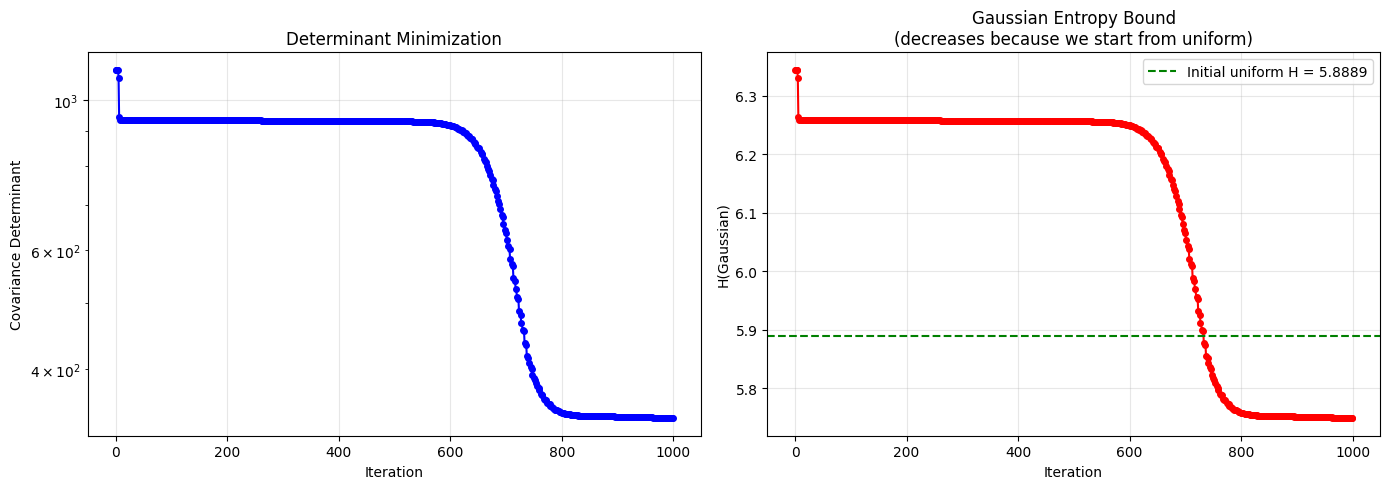

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

history = transformer.history_

# Determinant plot
axes[0].semilogy(history['iteration'], history['determinant'], 'b-o', markersize=4)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Covariance Determinant')
axes[0].set_title('Determinant Minimization')
axes[0].grid(True, alpha=0.3)

# Gaussian entropy plot
axes[1].plot(history['iteration'], history['gaussian_entropy'], 'r-o', markersize=4)
axes[1].axhline(entropy['original']['uniform_entropy'], color='g', linestyle='--', 
                label=f"Initial uniform H = {entropy['original']['uniform_entropy']:.4f}")
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('H(Gaussian)')
axes[1].set_title('Gaussian Entropy Bound\n(decreases because we start from uniform)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Visualize Before and After

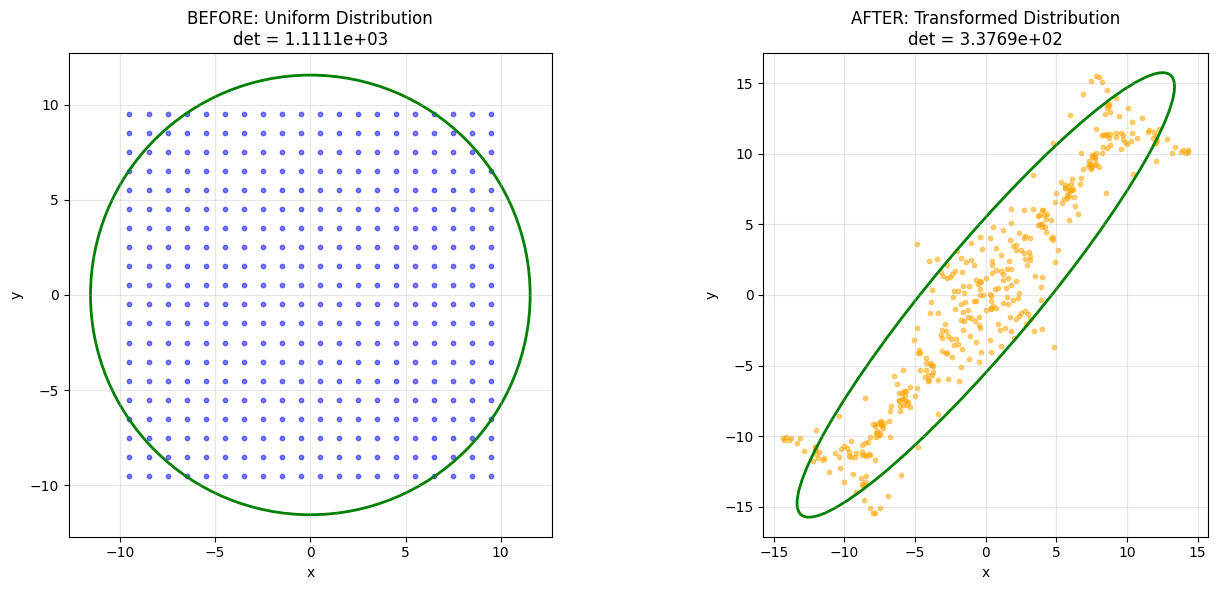

In [16]:
# Get points
points_original = df[['x', 'y']].values
points_transformed = df_transformed[['x', 'y']].values

# Compute stats
orig_mean = np.mean(points_original, axis=0)
orig_cov = np.cov(points_original, rowvar=False)
trans_mean = np.mean(points_transformed, axis=0)
trans_cov = np.cov(points_transformed, rowvar=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before transformation
ax0 = axes[0]
ax0.scatter(points_original[:, 0], points_original[:, 1], alpha=0.5, s=10, c='blue')
plot_covariance_ellipse(ax0, orig_mean, orig_cov, n_std=2,
                        fill=False, color='green', linewidth=2)
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_title(f"BEFORE: Uniform Distribution\ndet = {entropy['original']['determinant']:.4e}")
ax0.set_aspect('equal')
ax0.grid(True, alpha=0.3)

# After transformation
ax1 = axes[1]
ax1.scatter(points_transformed[:, 0], points_transformed[:, 1], alpha=0.5, s=10, c='orange')
plot_covariance_ellipse(ax1, trans_mean, trans_cov, n_std=2,
                        fill=False, color='green', linewidth=2)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f"AFTER: Transformed Distribution\ndet = {entropy['transformed']['determinant']:.4e}")
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Marginal Distributions

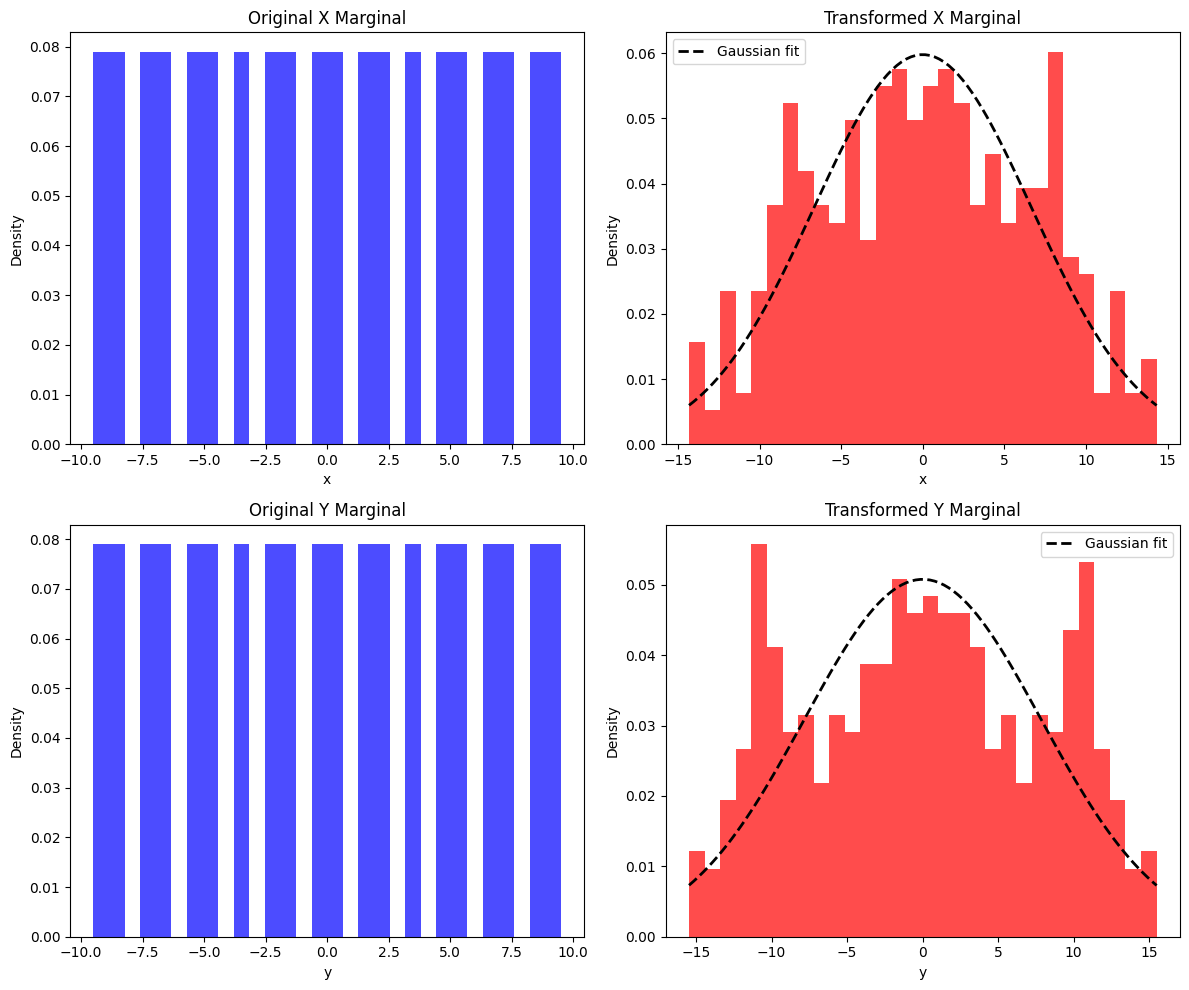

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# X marginal - Original
axes[0, 0].hist(points_original[:, 0], bins=30, density=True, alpha=0.7, color='blue')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Original X Marginal')

# X marginal - Transformed
axes[0, 1].hist(points_transformed[:, 0], bins=30, density=True, alpha=0.7, color='red')
x_range = np.linspace(points_transformed[:, 0].min(), points_transformed[:, 0].max(), 100)
mu_x = points_transformed[:, 0].mean()
std_x = points_transformed[:, 0].std()
gaussian_x = (1/(std_x * np.sqrt(2*np.pi))) * np.exp(-0.5*((x_range - mu_x)/std_x)**2)
axes[0, 1].plot(x_range, gaussian_x, 'k--', linewidth=2, label='Gaussian fit')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Transformed X Marginal')
axes[0, 1].legend()

# Y marginal - Original
axes[1, 0].hist(points_original[:, 1], bins=30, density=True, alpha=0.7, color='blue')
axes[1, 0].set_xlabel('y')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Original Y Marginal')

# Y marginal - Transformed
axes[1, 1].hist(points_transformed[:, 1], bins=30, density=True, alpha=0.7, color='red')
y_range = np.linspace(points_transformed[:, 1].min(), points_transformed[:, 1].max(), 100)
mu_y = points_transformed[:, 1].mean()
std_y = points_transformed[:, 1].std()
gaussian_y = (1/(std_y * np.sqrt(2*np.pi))) * np.exp(-0.5*((y_range - mu_y)/std_y)**2)
axes[1, 1].plot(y_range, gaussian_y, 'k--', linewidth=2, label='Gaussian fit')
axes[1, 1].set_xlabel('y')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Transformed Y Marginal')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Step 7: Save Transformed Data to CSV

In [18]:
# Save transformed data
output_csv = '/tmp/transformed_vectors.csv'
df_transformed.to_csv(output_csv, index=False)

print(f"Saved transformed data to: {output_csv}")
print()
print("First 5 rows:")
df_transformed.head()

Saved transformed data to: /tmp/transformed_vectors.csv

First 5 rows:


,x,y
0,-12.240170,-11.766220
1,-12.838348,-11.015958
2,-13.369835,-10.456693
3,-13.813183,-10.133368
4,-14.143197,-10.042885


## Summary

The `DataFrameTransformer` provides a simple high-level API:

```python
from entra import DataFrameTransformer

transformer = DataFrameTransformer(sigma=5.0)
df_transformed = transformer.fit_transform(df, columns=['x', 'y'])
```

Internally it:
1. Creates centers along coordinate axes
2. Builds `TensorBasis` with divergence-free basis functions
3. Optimizes coefficients using Levenberg-Marquardt
4. Transforms points while conserving entropy

**Key insight:** H(Gaussian) decreases during optimization because we start from a uniform distribution. The actual entropy is conserved (verified by k-NN estimator).